In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.Food101(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 101/101 [00:02<00:00, 49.62it/s]


In [12]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/food_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [13]:
# Mapping between CuPL and cls_name
special_class_mapping = {
}

In [14]:
# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name).replace(' ', '_')
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

In [15]:
# Create original gpt3 text features
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(encode_text, original_gpt3_label_texts_list)

100%|██████████| 101/101 [00:00<00:00, 117.08it/s]


In [16]:
# Hyperparameters for filtering outliers in gpt3 texts

# Minimum mean similarity
similarity_mean_threshold = 0.7

# Minimum similarity to be counted as dissimilar
similarity_count_threshold = 0.65
# Filter if it is dissimilar from more than (1-ratio) of the other texts
similarity_count_ratio = 0.5

In [17]:
# Filter out outliers in gpt3 text features
with torch.no_grad():
    # Remove duplicates
    unique_gpt3_prompts = {label_id: list(dict.fromkeys(original_gpt3_prompts[cls_name])) for label_id, cls_name in enumerate(cls_names_sorted)}
    _, _, unique_gpt3_text_features_cuda, _, _ = calc_features(encode_text, unique_gpt3_prompts.copy())

    unique_gpt3_text_similarity = [(features_cuda @ features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy() for features_cuda in unique_gpt3_text_features_cuda]
    unique_gpt3_text_similarity_mean = [np.nanmean(similarity, axis=0) for similarity in unique_gpt3_text_similarity]
    unique_gpt3_text_similarity_count_mean = [(similarity >= similarity_count_threshold).mean(axis=0) for similarity in unique_gpt3_text_similarity]
    filtered_gpt3_prompts = {label_id: [text for text, similarity_mean, similarity_count in zip(texts, similarity_means, similarity_counts) if similarity_mean >= similarity_mean_threshold and similarity_count >= similarity_count_ratio] for (label_id, texts), similarity_means, similarity_counts in zip(unique_gpt3_prompts.items(), unique_gpt3_text_similarity_mean, unique_gpt3_text_similarity_count_mean)}
    # Print filtered prompts
    outlier_gpt3_prompts = {label_id: [text for text, similarity_mean, similarity_count in zip(texts, similarity_means, similarity_counts) if not (similarity_mean >= similarity_mean_threshold and similarity_count >= similarity_count_ratio)] for (label_id, texts), similarity_means, similarity_counts in zip(unique_gpt3_prompts.items(), unique_gpt3_text_similarity_mean, unique_gpt3_text_similarity_count_mean)}
    top_filtered_label_id = None
    top_filtered_count = 0
    for label_id, texts in outlier_gpt3_prompts.items():
        filtered_count = len(texts)
        if filtered_count != 0:
            print(f'Filtered {filtered_count} outliers for ({label_id}){cls_names_sorted[label_id]}')
            print(texts)
            print()
            if filtered_count > top_filtered_count:
                top_filtered_count = filtered_count
                top_filtered_label_id = label_id

100%|██████████| 101/101 [00:00<00:00, 124.84it/s]

Filtered 1 outliers for (2)baklava
['From the photo, it is difficult to say definitively what the food is.']

Filtered 1 outliers for (4)beef_tartare
['Ramen with a soft boiled eggRamen noodles in a broth with a soft boiled egg.']

Filtered 2 outliers for (5)beet_salad
['The salad contains red and golden beets, mixed greens, mandarin oranges, feta cheese, and a honey balsamic vinaigrette.', 'In the photo, there is a dish with various greens and red chunks.']

Filtered 1 outliers for (6)beignets
['.']

Filtered 1 outliers for (7)bibimbap
['.']

Filtered 1 outliers for (8)bread_pudding
['The photo shows a dish with a brown crust and white interior.']

Filtered 1 outliers for (10)bruschetta
['The bread in this photo is toasted, and there is a red sauce on top.']

Filtered 1 outliers for (12)cannoli
['.']

Filtered 1 outliers for (14)carrot_cake
['.']

Filtered 1 outliers for (18)chicken_curry
['.']

Filtered 1 outliers for (25)club_sandwich
['The cl.']

Filtered 2 outliers for (26)crab_ca

Class: (97)takoyaki
(1)A ball-shaped Japanese snack made of a wheat flour-based batter and cooked in a special molded pan.
(17)A ball of batter with a piece of octopus in the center, fried in a special pan.
(19)A ball of batter filled with diced octopus,fried until crisp on the outside and fluffy on the inside,and brushed with a sweet and savory sauce.


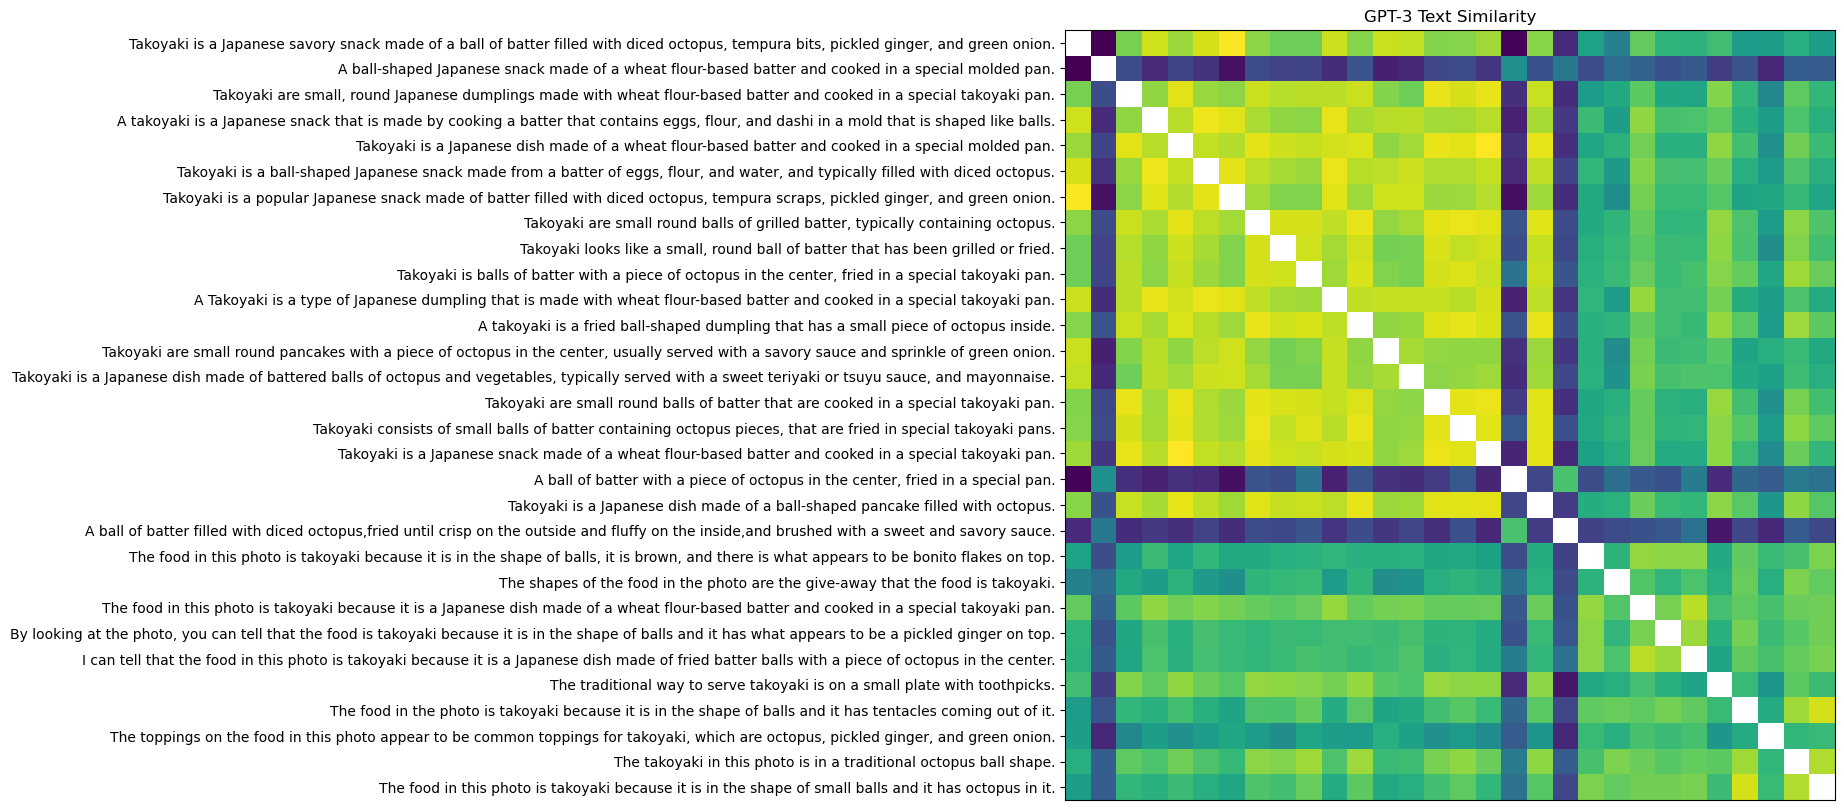

In [18]:
# Visualize dis-similarities of outliers
print(f'Class: ({top_filtered_label_id}){cls_names_sorted[top_filtered_label_id]}')
ylabels = unique_gpt3_prompts[top_filtered_label_id]
for text in outlier_gpt3_prompts[top_filtered_label_id]:
    print(f'({ylabels.index(text)}){text}')
plt.figure(figsize=(12, 10))
plt.imshow(unique_gpt3_text_similarity[top_filtered_label_id])
plt.xticks([])
plt.yticks(np.arange(0, len(ylabels)), ylabels)
plt.title('GPT-3 Text Similarity')
plt.show()

In [19]:
# Create filtered gpt3 text features
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[label_id] for label_id in range(len(cls_names_sorted))}
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(encode_text, filtered_gpt3_label_texts_list)

100%|██████████| 101/101 [00:00<00:00, 126.90it/s]


In [20]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [21]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 101/101 [03:34<00:00,  2.12s/it]


In [22]:
import sklearn.metrics

def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [23]:
# Combine template text with gpt3 text features
combined_original_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_gpt3_text_features_cuda)]
combined_filtered_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_gpt3_text_features_cuda)]
combined_original_gpt3_cls_features_cuda = []
combined_filtered_gpt3_cls_features_cuda = []
for class_embeddings in combined_original_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_gpt3_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_gpt3_cls_features_cuda.append(class_embedding)
combined_original_gpt3_cls_features_cuda = torch.vstack(combined_original_gpt3_cls_features_cuda)
combined_filtered_gpt3_cls_features_cuda = torch.vstack(combined_filtered_gpt3_cls_features_cuda)

In [24]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_gpt3_cls_acc, original_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_cls_features_cuda)
original_gpt3_text_acc, original_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_text_features_cuda)
filtered_gpt3_cls_acc, filtered_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_cls_features_cuda)
filtered_gpt3_text_acc, filtered_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_text_features_cuda)
combined_original_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_cls_features_cuda)
combined_original_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_text_features_cuda)
combined_filtered_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_cls_features_cuda)
combined_filtered_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_text_features_cuda)

In [25]:
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (centroid): {original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (individual avg): {original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (centroid): {filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (individual avg): {filtered_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (centroid): {combined_original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (individual avg): {combined_original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (centroid): {combined_filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (individual avg): {combined_filtered_gpt3_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 81.86%
Accuracy of CLIP with text template (centroid): 84.06%
Accuracy of CLIP with text template (individual avg): 83.89%
Accuracy of CLIP with original GPT-3 text (centroid): 86.10%
Accuracy of CLIP with original GPT-3 text (individual avg): 85.81%
Accuracy of CLIP with filtered GPT-3 text (centroid): 86.17%
Accuracy of CLIP with filtered GPT-3 text (individual avg): 85.72%
Accuracy of CLIP with combined original GPT-3 text (centroid): 85.24%
Accuracy of CLIP with combined original GPT-3 text (individual avg): 85.20%
Accuracy of CLIP with combined filtered GPT-3 text (centroid): 85.22%
Accuracy of CLIP with combined filtered GPT-3 text (individual avg): 85.15%


In [26]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_gpt3_text_individual_features_cuda = list(torch.stack(original_gpt3_text_features_cuda).permute(1, 0, 2))
original_gpt3_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_gpt3_text_individual_features_cuda])

In [27]:
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original GPT-3 text (one text on all images): mean={original_gpt3_text_individual_acc.mean()*100:.2f}%, std={original_gpt3_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=81.78%, std=0.028940349866202916
Accuracy of CLIP with original GPT-3 text (one text on all images): mean=78.62%, std=0.02670018905794761


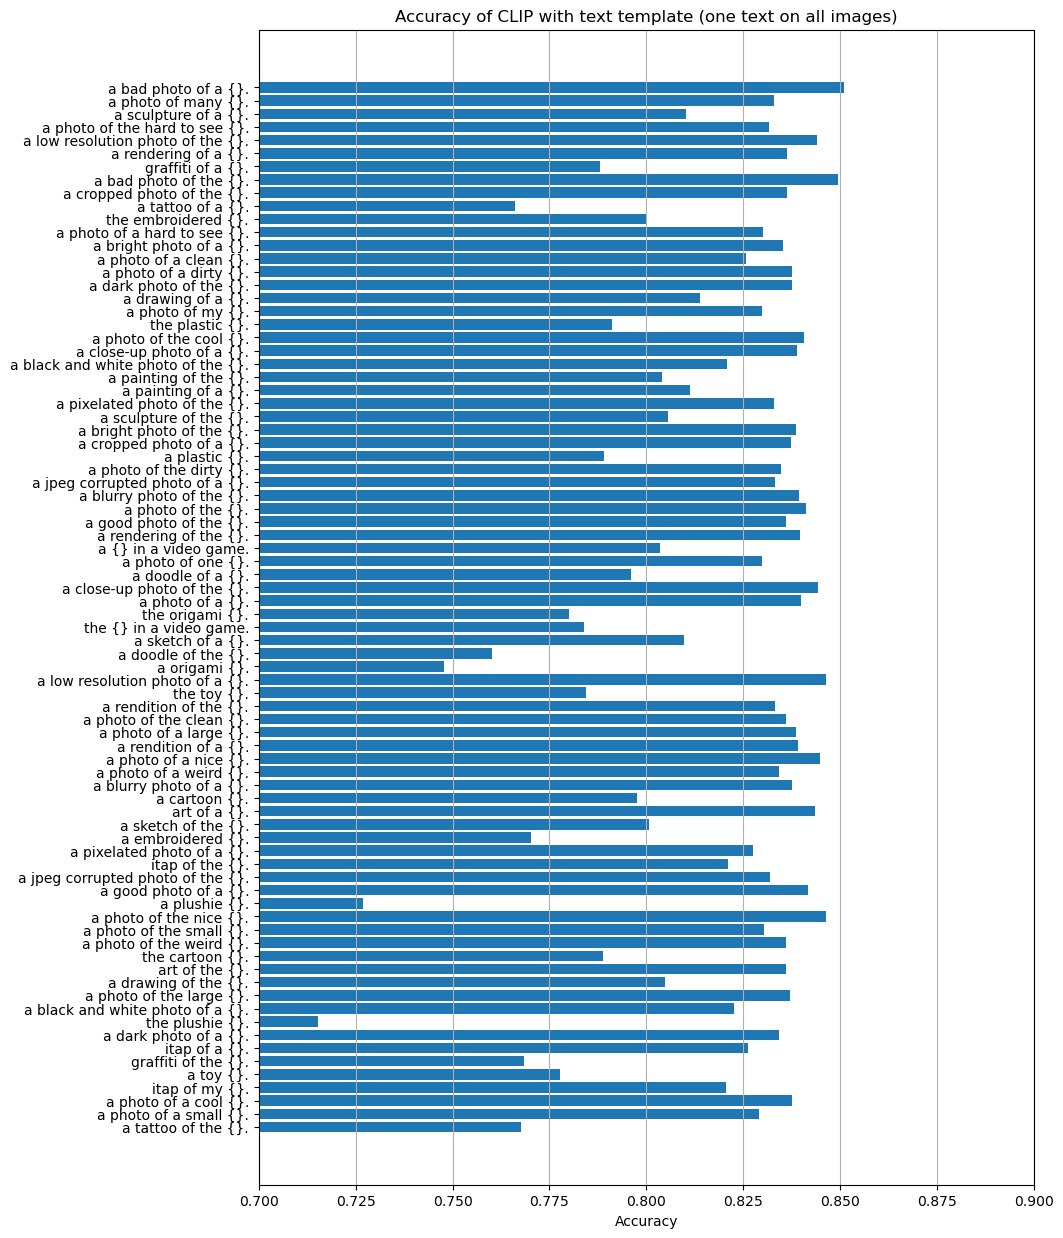

In [28]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy of CLIP with text template (one text on all images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [29]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [30]:
# Calculate similarity between image features and text features
img_cls_name_similarity = calc_features_similarity(img_features_cuda, cls_name_features_cuda)
img_template_cls_similarity = calc_features_similarity(img_features_cuda, template_cls_features_cuda)
img_template_text_similarity = calc_features_similarity(img_features_cuda, template_text_features_cuda)
img_original_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, original_gpt3_cls_features_cuda)
img_original_gpt3_text_similarity = calc_features_similarity(img_features_cuda, original_gpt3_text_features_cuda)
img_filtered_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_cls_features_cuda)
img_filtered_gpt3_text_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_text_features_cuda)

In [31]:
def print_top_pairs(similarity, text, *, top=10, xlabel='', ylabel='', coordinates=None):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        if coordinates is None:
            print(f'Rank {idx+1}: ({label1}){ylabel}{cls_names_sorted[label1]} - ({label2}){xlabel}{cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')
        else:
            print(f'Rank {idx+1}: ({label1}){ylabel}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}){cls_names_sorted[label1]} - ({label2}){xlabel}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}){cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')

In [32]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, similarity.shape[0], 5))
    plt.yticks(np.arange(0, similarity.shape[1], 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [33]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, cm.shape[0], 5))
    plt.yticks(np.arange(0, cm.shape[1], 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [34]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

In [35]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_cm(cm, title + ' Confusion Matrix')

Class name similarity mean: 0.7060546875
Class name similarity std: 0.055145263671875
Rank 1: (45)frozen_yogurt - (58)ice_cream, similarity: 0.9013671875
Rank 2: (72)pancakes - (100)waffles, similarity: 0.8916015625
Rank 3: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.890625
Rank 4: (37)filet_mignon - (93)steak, similarity: 0.87744140625
Rank 5: (38)fish_and_chips - (40)french_fries, similarity: 0.87646484375
Rank 6: (66)nachos - (96)tacos, similarity: 0.873046875
Rank 7: (86)sashimi - (95)sushi, similarity: 0.87158203125
Rank 8: (4)beef_tartare - (99)tuna_tartare, similarity: 0.86572265625
Rank 9: (76)pizza - (93)steak, similarity: 0.865234375
Rank 10: (21)chocolate_cake - (29)cup_cakes, similarity: 0.8642578125


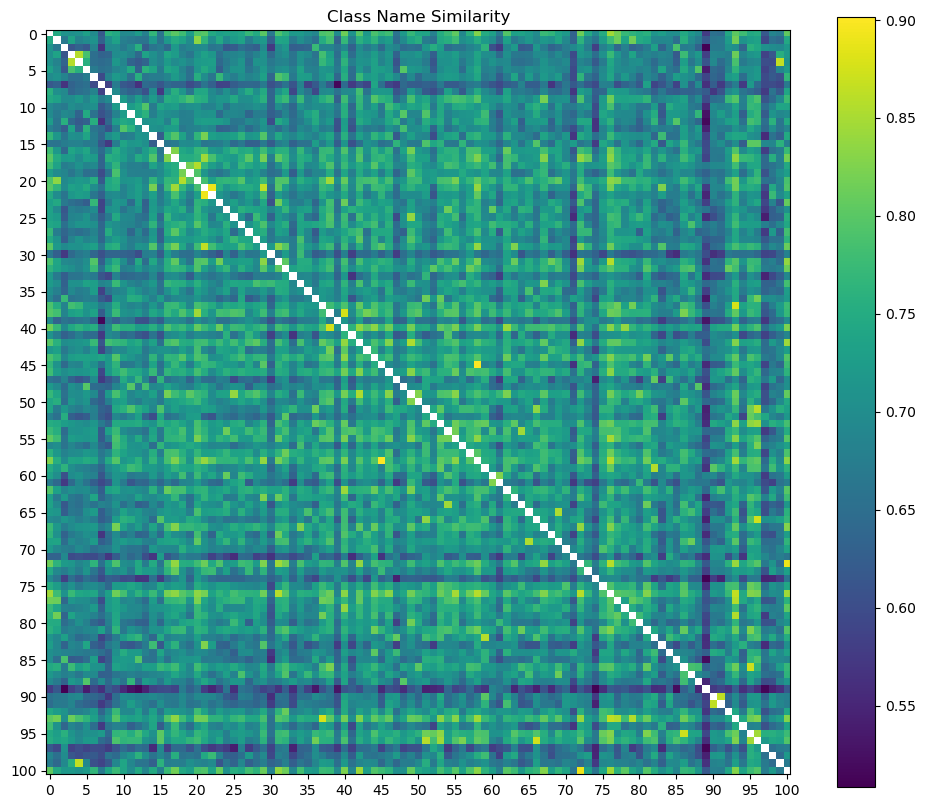

Text template similarity mean: 0.70361328125
Text template similarity std: 0.057373046875
Rank 1: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.90283203125
Rank 2: (45)frozen_yogurt - (58)ice_cream, similarity: 0.8994140625
Rank 3: (4)beef_tartare - (99)tuna_tartare, similarity: 0.8974609375
Rank 4: (86)sashimi - (95)sushi, similarity: 0.8896484375
Rank 5: (37)filet_mignon - (93)steak, similarity: 0.8876953125
Rank 6: (72)pancakes - (100)waffles, similarity: 0.88720703125
Rank 7: (53)hamburger - (93)steak, similarity: 0.88671875
Rank 8: (77)pork_chop - (93)steak, similarity: 0.88134765625
Rank 9: (53)hamburger - (55)hot_dog, similarity: 0.86474609375
Rank 10: (79)prime_rib - (93)steak, similarity: 0.86474609375


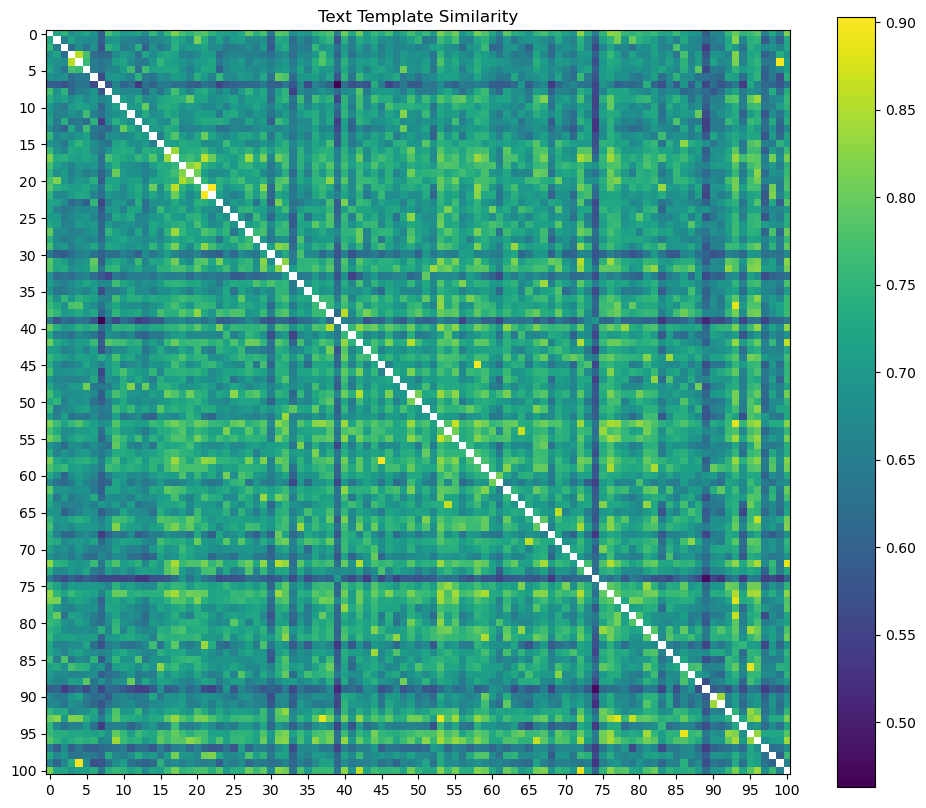

Original gpt-3 text similarity mean: 0.71533203125
Original gpt-3 text similarity std: 0.061492919921875
Rank 1: (37)filet_mignon - (93)steak, similarity: 0.93505859375
Rank 2: (45)frozen_yogurt - (58)ice_cream, similarity: 0.9306640625
Rank 3: (4)beef_tartare - (99)tuna_tartare, similarity: 0.91650390625
Rank 4: (86)sashimi - (95)sushi, similarity: 0.91552734375
Rank 5: (79)prime_rib - (93)steak, similarity: 0.9150390625
Rank 6: (77)pork_chop - (93)steak, similarity: 0.90576171875
Rank 7: (53)hamburger - (55)hot_dog, similarity: 0.90478515625
Rank 8: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.90185546875
Rank 9: (72)pancakes - (100)waffles, similarity: 0.90087890625
Rank 10: (54)hot_and_sour_soup - (64)miso_soup, similarity: 0.8984375


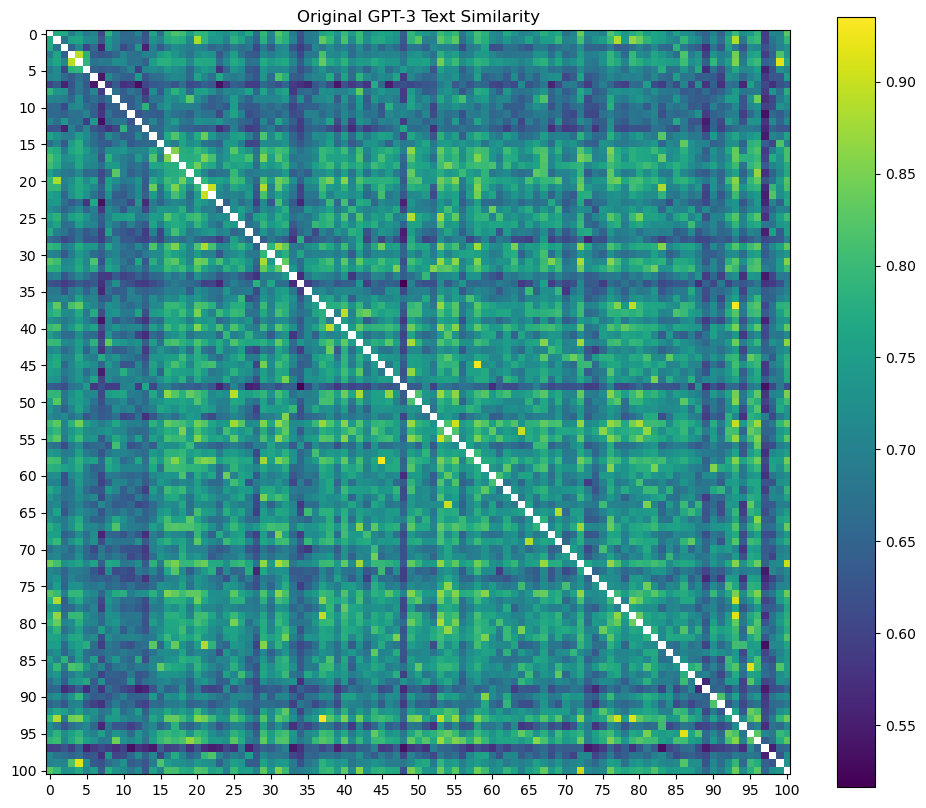

Filtered gpt-3 text similarity mean: 0.708984375
Filtered gpt-3 text similarity std: 0.06402587890625
Rank 1: (37)filet_mignon - (93)steak, similarity: 0.9365234375
Rank 2: (45)frozen_yogurt - (58)ice_cream, similarity: 0.92724609375
Rank 3: (86)sashimi - (95)sushi, similarity: 0.9140625
Rank 4: (79)prime_rib - (93)steak, similarity: 0.91162109375
Rank 5: (4)beef_tartare - (99)tuna_tartare, similarity: 0.91015625
Rank 6: (77)pork_chop - (93)steak, similarity: 0.90576171875
Rank 7: (53)hamburger - (55)hot_dog, similarity: 0.904296875
Rank 8: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.9013671875
Rank 9: (72)pancakes - (100)waffles, similarity: 0.90087890625
Rank 10: (53)hamburger - (93)steak, similarity: 0.89697265625


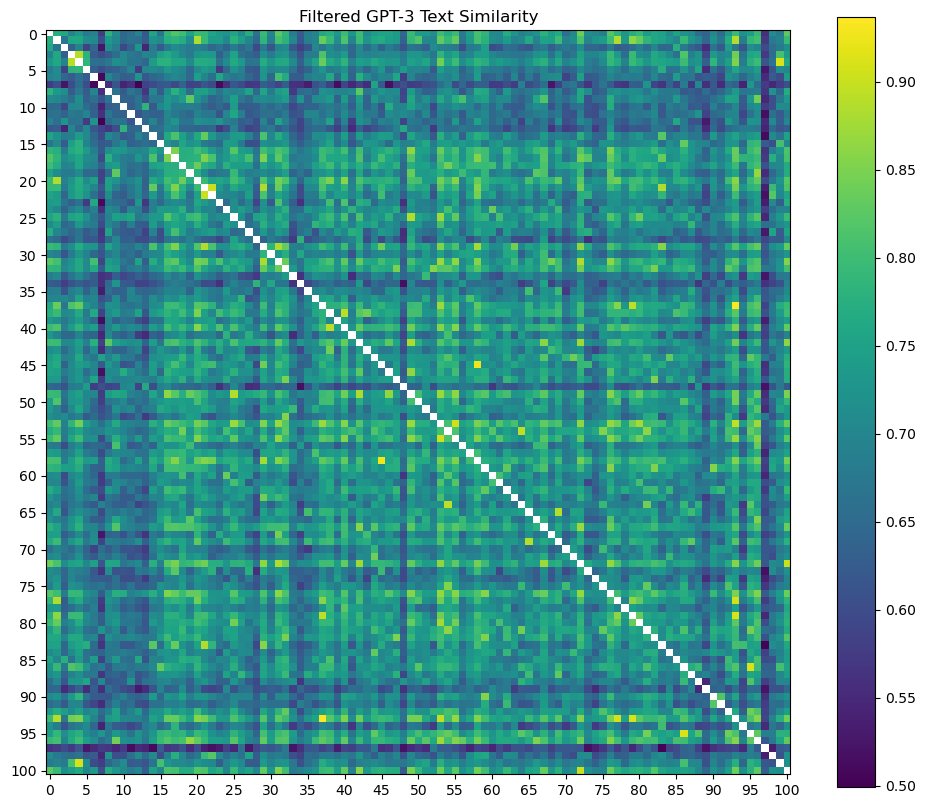

In [36]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')
visualize_auto_similarity(template_masked_similarity, 'Text Template')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text')

Image similarity mean: 0.830078125
Image similarity std: 0.04644775390625
Rank 1: (37)filet_mignon - (93)steak, similarity: 0.9873046875
Rank 2: (47)gnocchi - (82)ravioli, similarity: 0.9736328125
Rank 3: (77)pork_chop - (93)steak, similarity: 0.970703125
Rank 4: (37)filet_mignon - (77)pork_chop, similarity: 0.97021484375
Rank 5: (4)beef_tartare - (99)tuna_tartare, similarity: 0.9697265625
Rank 6: (22)chocolate_mousse - (98)tiramisu, similarity: 0.96923828125
Rank 7: (79)prime_rib - (93)steak, similarity: 0.96875
Rank 8: (9)breakfast_burrito - (19)chicken_quesadilla, similarity: 0.96435546875
Rank 9: (0)apple_pie - (8)bread_pudding, similarity: 0.96337890625
Rank 10: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.962890625


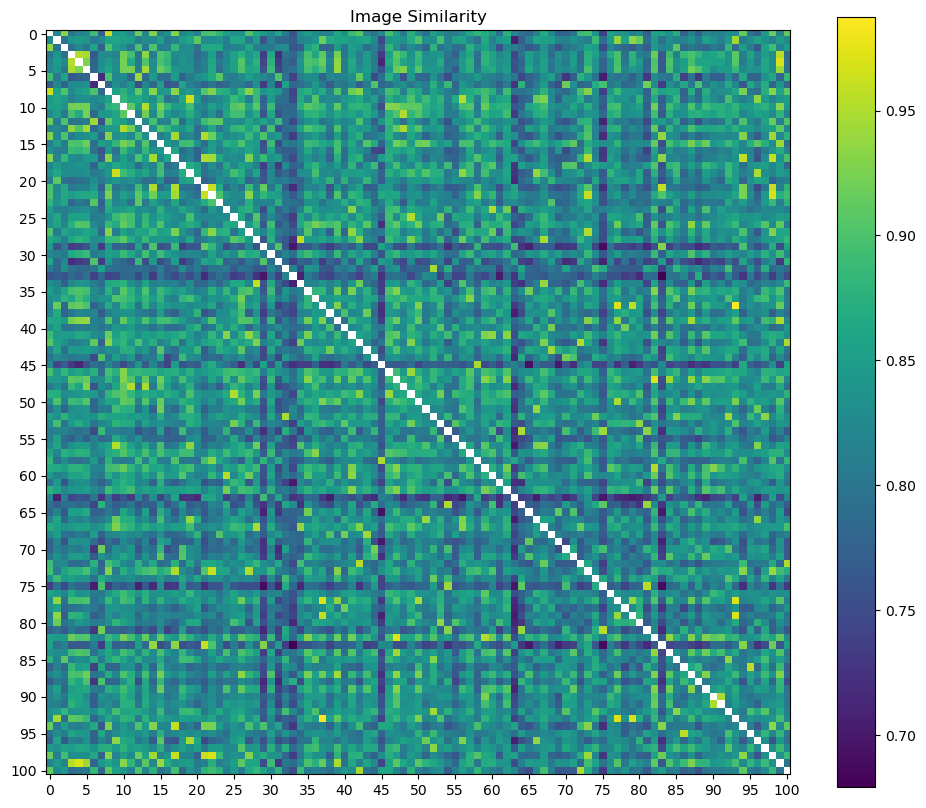

Image to class name similarity mean: 0.2001953125
Image to class name similarity std: 0.025604248046875
Image to class name similarity diagonal mean: 0.304443359375
Image to class name similarity diagonal std: 0.0145721435546875
Image to class name similarity non-diagonal mean: 0.19921875
Image to class name similarity non-diagonal std: 0.0234527587890625
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.5283203125
Rank 1: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, similarity: 0.31640625
Rank 2: (99)(Image)tuna_tartare - (4)(Text)beef_tartare, similarity: 0.30078125
Rank 3: (52)(Image)gyoza - (32)(Text)dumplings, similarity: 0.294189453125
Rank 4: (64)(Image)miso_soup - (54)(Text)hot_and_sour_soup, similarity: 0.292724609375
Rank 5: (11)(Image)caesar_salad - (48)(Text)greek_salad, similarity: 0.287841796875
Rank 6: (54)(Image)hot_and_sour_soup - (64)(Text)miso_soup, similarity: 0.28759765625
Rank 7: (60)(Image)lobster_bisque - (24)(Text)clam_chowder, simi

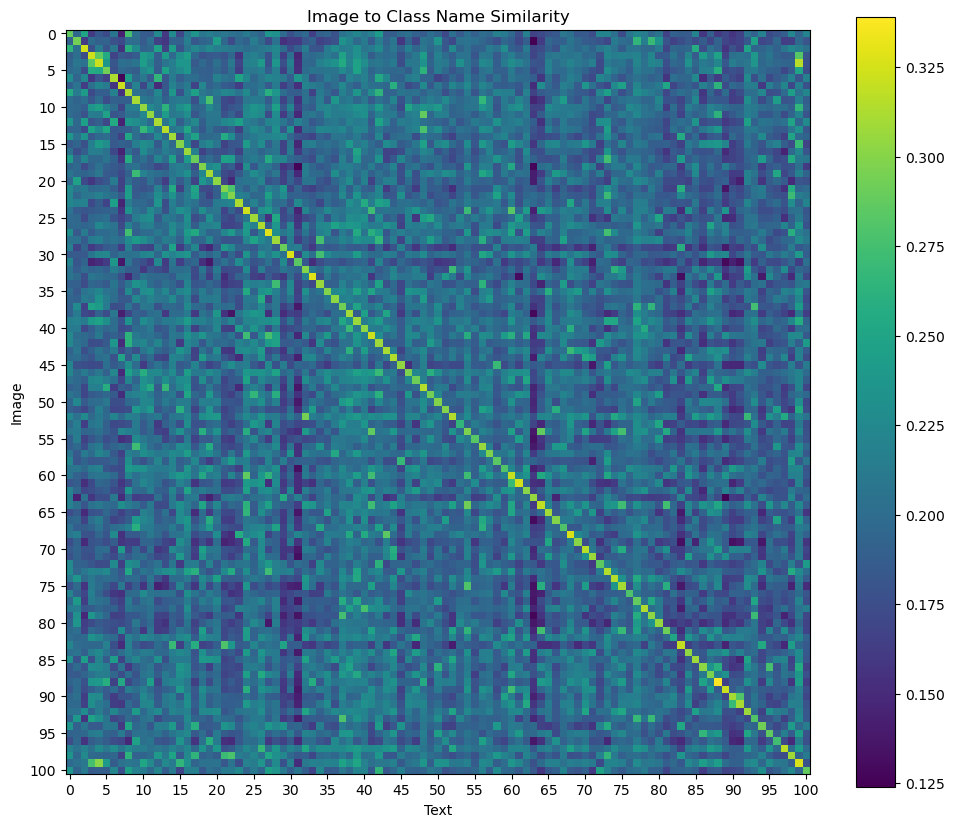

Rank 1: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, error rate: 0.3433333333333333
Rank 2: (0)(Image)apple_pie - (8)(Text)bread_pudding, error rate: 0.29333333333333333
Rank 3: (93)(Image)steak - (37)(Text)filet_mignon, error rate: 0.2833333333333333
Rank 4: (54)(Image)hot_and_sour_soup - (41)(Text)french_onion_soup, error rate: 0.21666666666666667
Rank 5: (96)(Image)tacos - (19)(Text)chicken_quesadilla, error rate: 0.2
Rank 6: (54)(Image)hot_and_sour_soup - (64)(Text)miso_soup, error rate: 0.19333333333333333
Rank 7: (17)(Image)cheesecake - (73)(Text)panna_cotta, error rate: 0.16333333333333333
Rank 8: (11)(Image)caesar_salad - (48)(Text)greek_salad, error rate: 0.16333333333333333
Rank 9: (82)(Image)ravioli - (60)(Text)lobster_bisque, error rate: 0.15
Rank 10: (29)(Image)cup_cakes - (83)(Text)red_velvet_cake, error rate: 0.15
Rank 11: (53)(Image)hamburger - (80)(Text)pulled_pork_sandwich, error rate: 0.14333333333333334
Rank 12: (52)(Image)gyoza - (32)(Text)dumplings, error rate

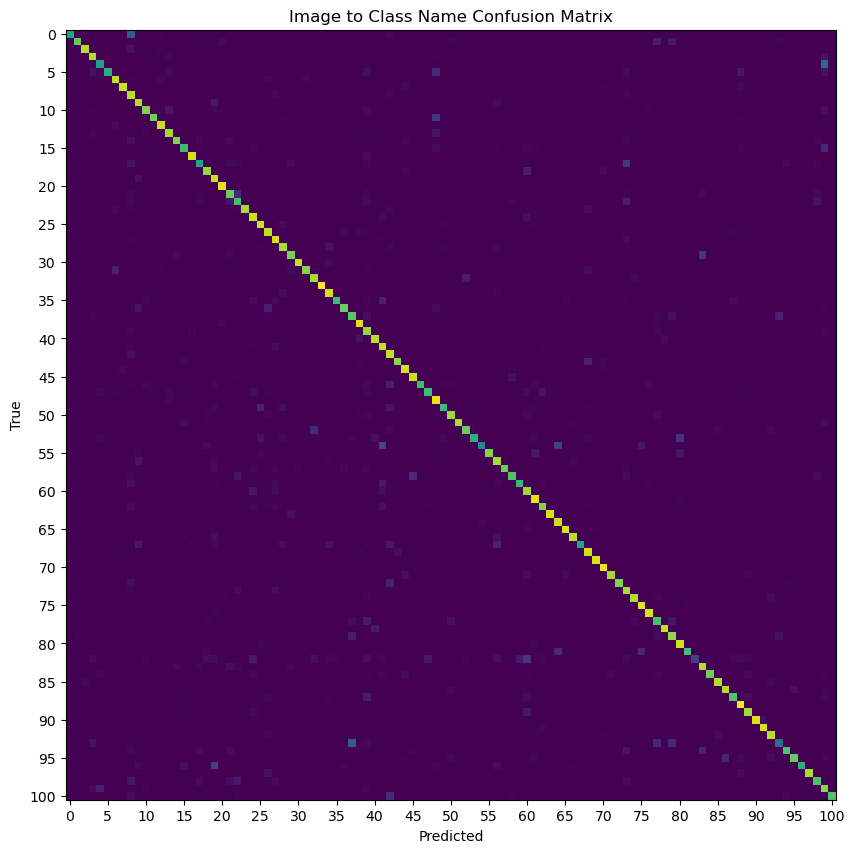

Image to text template (centroid) similarity mean: 0.2105712890625
Image to text template (centroid) similarity std: 0.02783203125
Image to text template (centroid) similarity diagonal mean: 0.3251953125
Image to text template (centroid) similarity diagonal std: 0.01323699951171875
Image to text template (centroid) similarity non-diagonal mean: 0.20947265625
Image to text template (centroid) similarity non-diagonal std: 0.0254364013671875
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.552734375
Rank 1: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, similarity: 0.326416015625
Rank 2: (99)(Image)tuna_tartare - (4)(Text)beef_tartare, similarity: 0.32080078125
Rank 3: (52)(Image)gyoza - (32)(Text)dumplings, similarity: 0.3154296875
Rank 4: (54)(Image)hot_and_sour_soup - (64)(Text)miso_soup, similarity: 0.312255859375
Rank 5: (64)(Image)miso_soup - (54)(Text)hot_and_sour_soup, similarity: 0.3095703125
Rank 6: (68)(Image)onion_rings - (43)(Text)fri

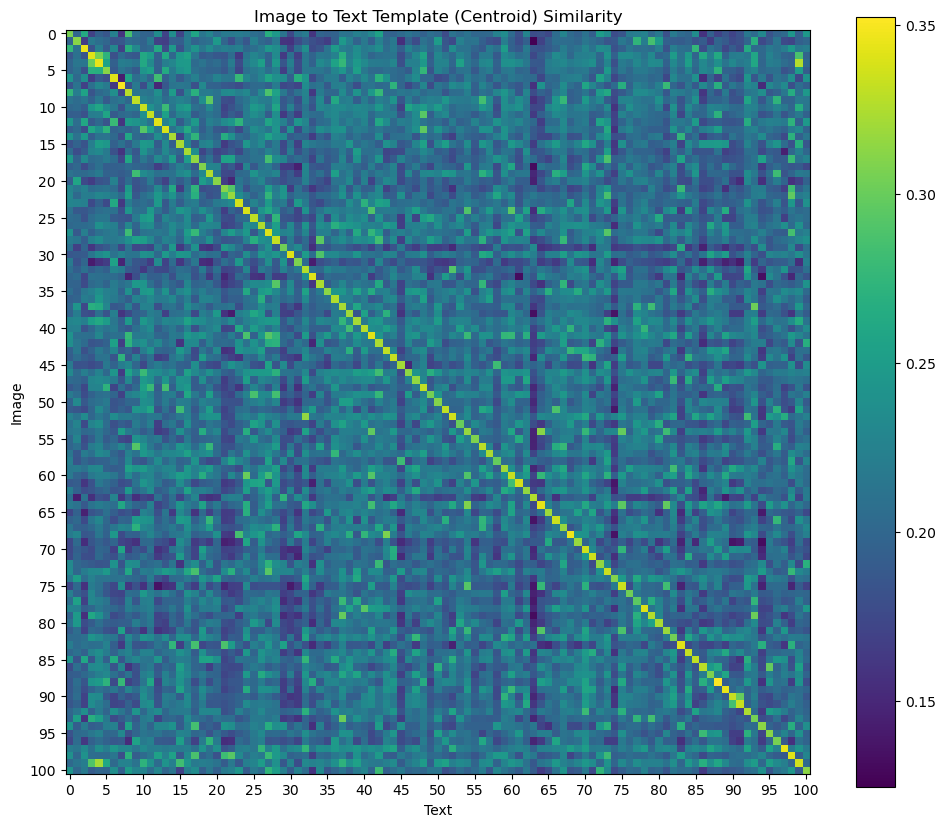

Rank 1: (93)(Image)steak - (37)(Text)filet_mignon, error rate: 0.3433333333333333
Rank 2: (54)(Image)hot_and_sour_soup - (64)(Text)miso_soup, error rate: 0.32
Rank 3: (0)(Image)apple_pie - (8)(Text)bread_pudding, error rate: 0.20333333333333334
Rank 4: (49)(Image)grilled_cheese_sandwich - (25)(Text)club_sandwich, error rate: 0.16
Rank 5: (29)(Image)cup_cakes - (83)(Text)red_velvet_cake, error rate: 0.15666666666666668
Rank 6: (99)(Image)tuna_tartare - (4)(Text)beef_tartare, error rate: 0.15333333333333332
Rank 7: (58)(Image)ice_cream - (45)(Text)frozen_yogurt, error rate: 0.14666666666666667
Rank 8: (54)(Image)hot_and_sour_soup - (41)(Text)french_onion_soup, error rate: 0.13
Rank 9: (79)(Image)prime_rib - (37)(Text)filet_mignon, error rate: 0.12666666666666668
Rank 10: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, error rate: 0.12666666666666668
Rank 11: (17)(Image)cheesecake - (73)(Text)panna_cotta, error rate: 0.12
Rank 12: (21)(Image)chocolate_cake - (22)(Text)chocolate_mousse, e

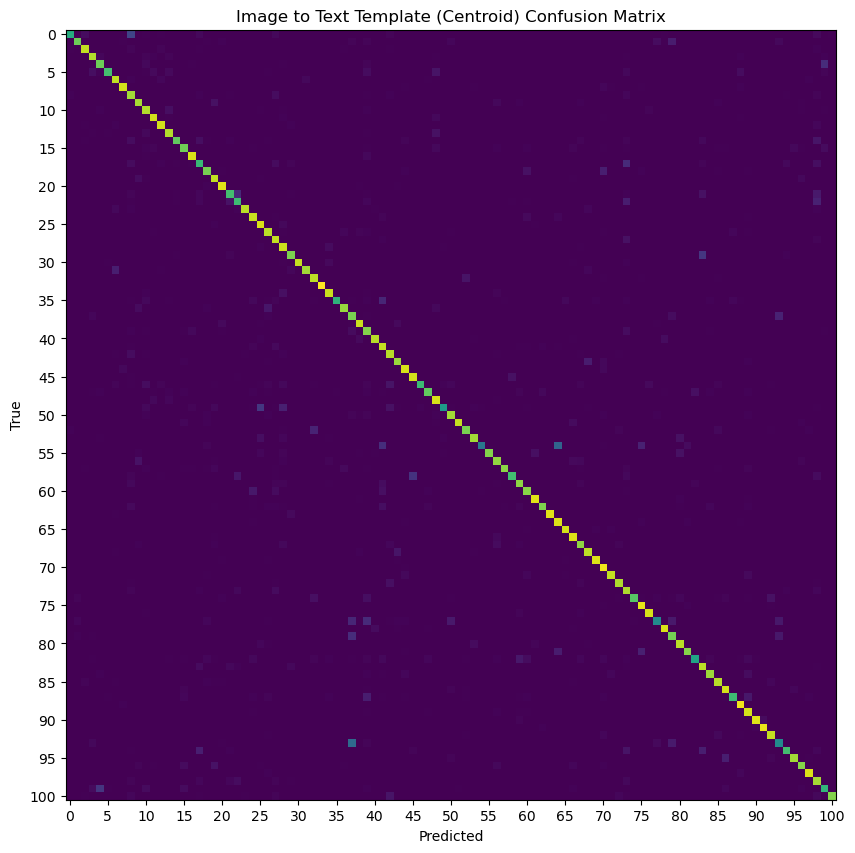

Image to text template (individual avg) similarity mean: 0.19405469298362732
Image to text template (individual avg) similarity std: 0.02567593939602375
Image to text template (individual avg) similarity diagonal mean: 0.2997756898403168
Image to text template (individual avg) similarity diagonal std: 0.01267746277153492
Image to text template (individual avg) similarity non-diagonal mean: 0.19299748539924622
Image to text template (individual avg) similarity non-diagonal std: 0.023480890318751335
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.5532621145248413
Rank 1: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, similarity: 0.3017578125
Rank 2: (99)(Image)tuna_tartare - (4)(Text)beef_tartare, similarity: 0.2958984375
Rank 3: (54)(Image)hot_and_sour_soup - (64)(Text)miso_soup, similarity: 0.289306640625
Rank 4: (64)(Image)miso_soup - (54)(Text)hot_and_sour_soup, similarity: 0.2890625
Rank 5: (52)(Image)gyoza - (32)(Text)dumplings, simi

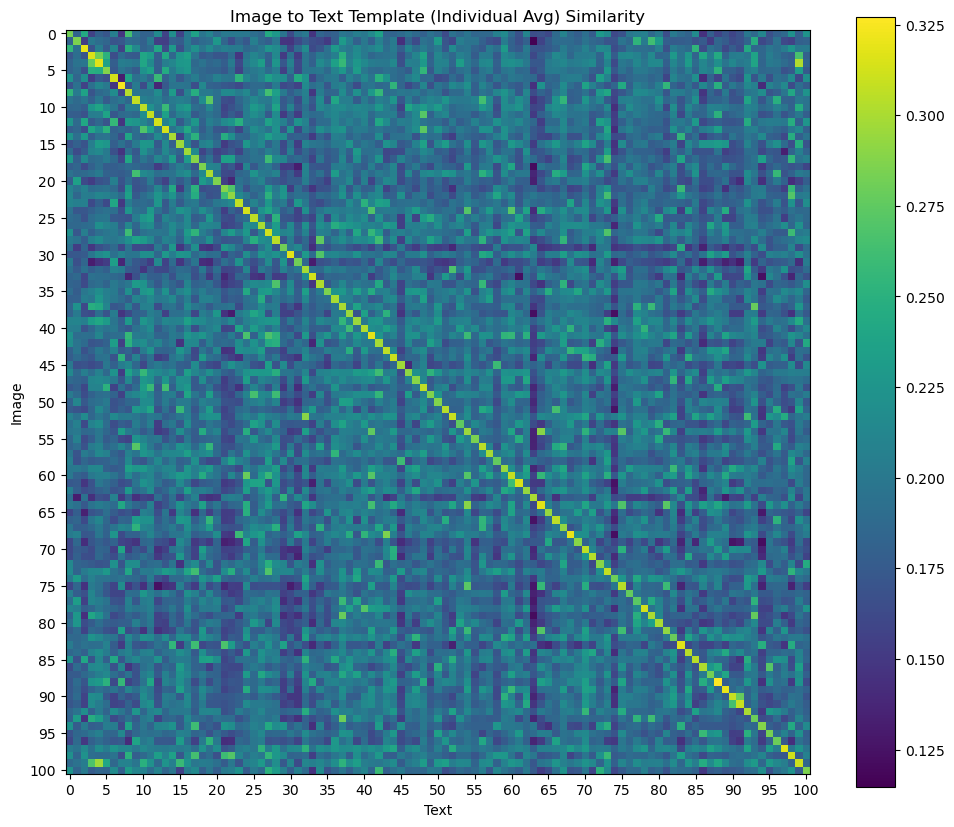

Rank 1: (93)(Image)steak - (37)(Text)filet_mignon, error rate: 0.4266666666666667
Rank 2: (54)(Image)hot_and_sour_soup - (64)(Text)miso_soup, error rate: 0.2866666666666667
Rank 3: (0)(Image)apple_pie - (8)(Text)bread_pudding, error rate: 0.20333333333333334
Rank 4: (79)(Image)prime_rib - (37)(Text)filet_mignon, error rate: 0.16333333333333333
Rank 5: (29)(Image)cup_cakes - (83)(Text)red_velvet_cake, error rate: 0.15666666666666668
Rank 6: (58)(Image)ice_cream - (45)(Text)frozen_yogurt, error rate: 0.15
Rank 7: (49)(Image)grilled_cheese_sandwich - (25)(Text)club_sandwich, error rate: 0.14666666666666667
Rank 8: (99)(Image)tuna_tartare - (4)(Text)beef_tartare, error rate: 0.14333333333333334
Rank 9: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, error rate: 0.13333333333333333
Rank 10: (17)(Image)cheesecake - (73)(Text)panna_cotta, error rate: 0.12666666666666668
Rank 11: (77)(Image)pork_chop - (37)(Text)filet_mignon, error rate: 0.12333333333333334
Rank 12: (54)(Image)hot_and_sour_so

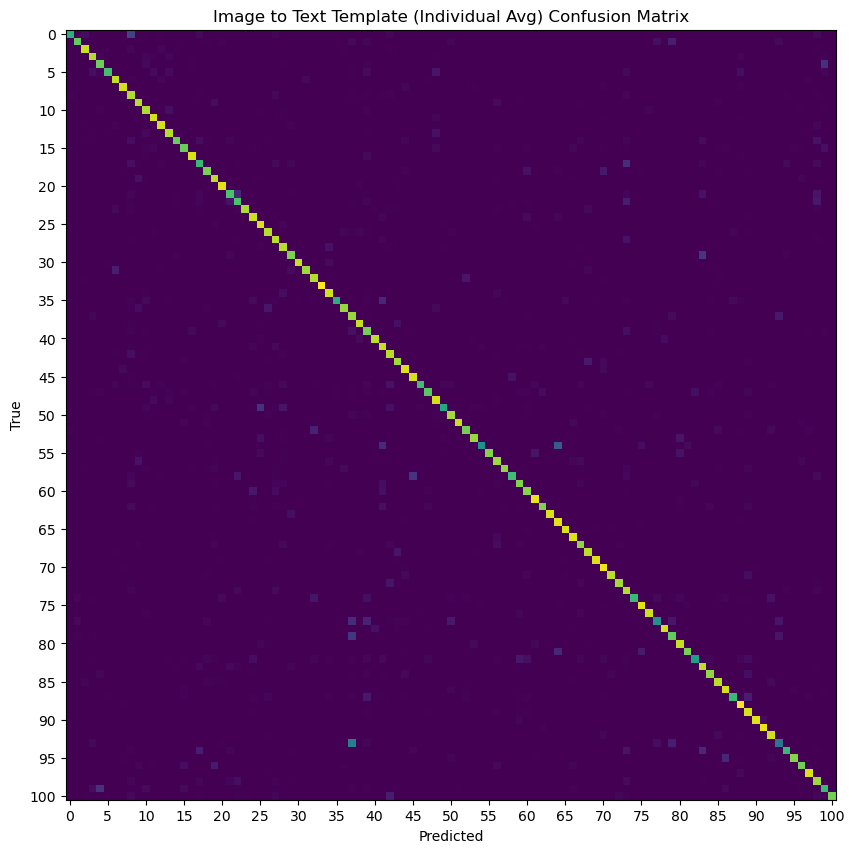

Image to original gpt-3 text (centroid) similarity mean: 0.2086181640625
Image to original gpt-3 text (centroid) similarity std: 0.0283355712890625
Image to original gpt-3 text (centroid) similarity diagonal mean: 0.3271484375
Image to original gpt-3 text (centroid) similarity diagonal std: 0.01421356201171875
Image to original gpt-3 text (centroid) similarity non-diagonal mean: 0.207275390625
Image to original gpt-3 text (centroid) similarity non-diagonal std: 0.02581787109375
Image to original gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.578125
Rank 1: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, similarity: 0.320556640625
Rank 2: (64)(Image)miso_soup - (54)(Text)hot_and_sour_soup, similarity: 0.31494140625
Rank 3: (52)(Image)gyoza - (32)(Text)dumplings, similarity: 0.314697265625
Rank 4: (54)(Image)hot_and_sour_soup - (64)(Text)miso_soup, similarity: 0.314453125
Rank 5: (75)(Image)pho - (54)(Text)hot_and_sour_soup, similarity: 0.308349609375
Rank 

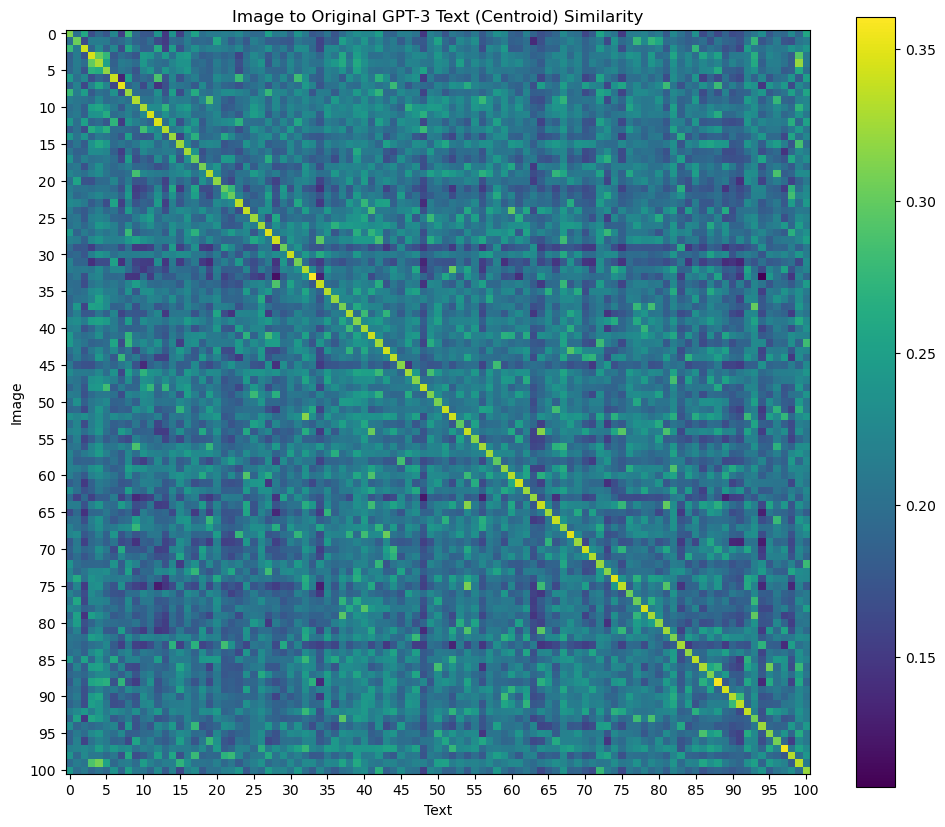

Rank 1: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, error rate: 0.27
Rank 2: (93)(Image)steak - (37)(Text)filet_mignon, error rate: 0.22666666666666666
Rank 3: (37)(Image)filet_mignon - (93)(Text)steak, error rate: 0.19
Rank 4: (58)(Image)ice_cream - (45)(Text)frozen_yogurt, error rate: 0.16333333333333333
Rank 5: (29)(Image)cup_cakes - (83)(Text)red_velvet_cake, error rate: 0.12333333333333334
Rank 6: (0)(Image)apple_pie - (8)(Text)bread_pudding, error rate: 0.10666666666666667
Rank 7: (22)(Image)chocolate_mousse - (98)(Text)tiramisu, error rate: 0.1
Rank 8: (95)(Image)sushi - (86)(Text)sashimi, error rate: 0.09666666666666666
Rank 9: (21)(Image)chocolate_cake - (98)(Text)tiramisu, error rate: 0.09666666666666666
Rank 10: (93)(Image)steak - (79)(Text)prime_rib, error rate: 0.09666666666666666
Rank 11: (15)(Image)ceviche - (99)(Text)tuna_tartare, error rate: 0.08666666666666667
Rank 12: (43)(Image)fried_calamari - (68)(Text)onion_rings, error rate: 0.08333333333333333
Rank 13: (73

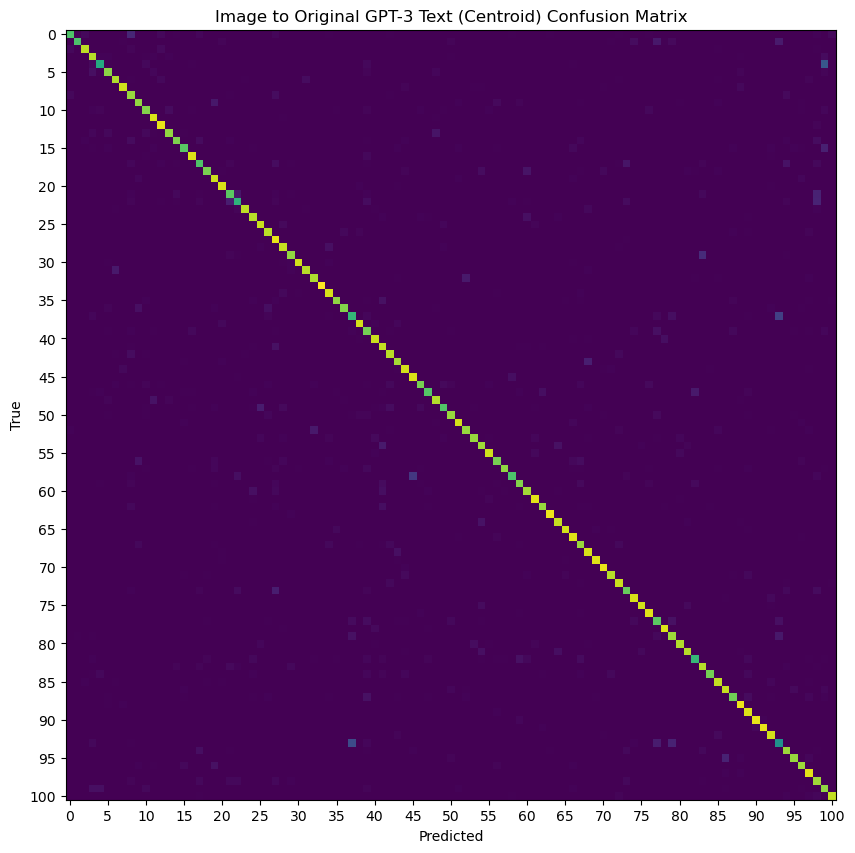

Image to original gpt-3 text (individual avg) similarity mean: 0.19644682109355927
Image to original gpt-3 text (individual avg) similarity std: 0.026626577600836754
Image to original gpt-3 text (individual avg) similarity diagonal mean: 0.30806678533554077
Image to original gpt-3 text (individual avg) similarity diagonal std: 0.013366647064685822
Image to original gpt-3 text (individual avg) similarity non-diagonal mean: 0.19533061981201172
Image to original gpt-3 text (individual avg) similarity non-diagonal std: 0.024257812649011612
Image to original gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.577155590057373
Rank 1: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, similarity: 0.30029296875
Rank 2: (64)(Image)miso_soup - (54)(Text)hot_and_sour_soup, similarity: 0.295166015625
Rank 3: (52)(Image)gyoza - (32)(Text)dumplings, similarity: 0.294189453125
Rank 4: (54)(Image)hot_and_sour_soup - (64)(Text)miso_soup, similarity: 0.293701171875
Rank 5: (

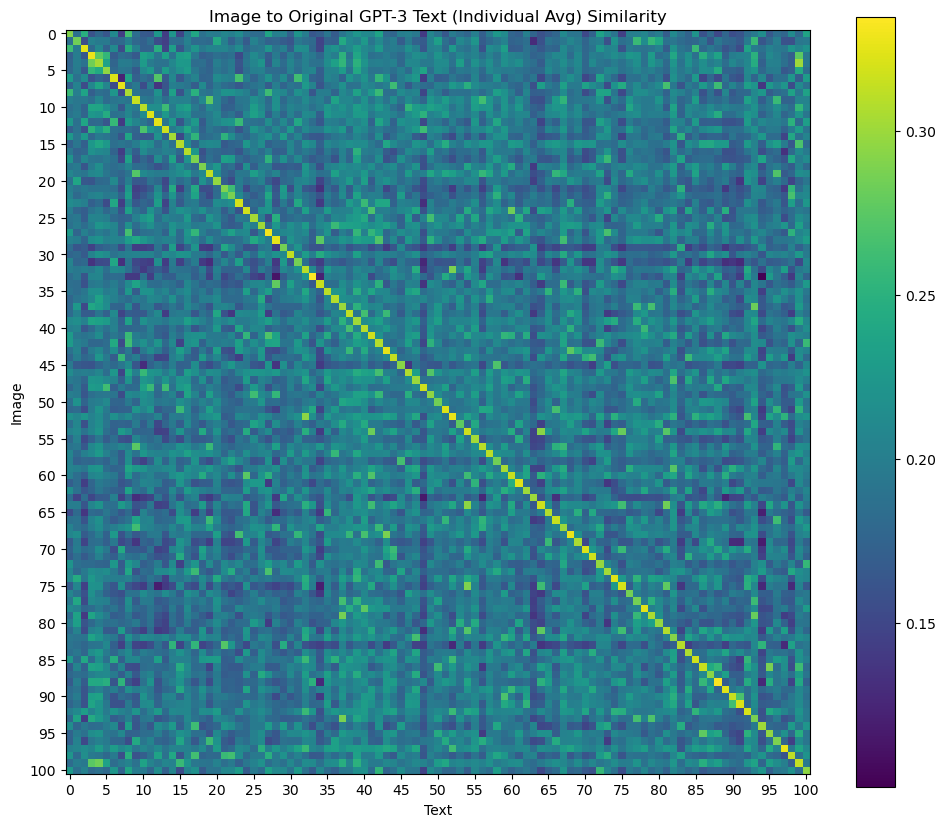

Rank 1: (93)(Image)steak - (37)(Text)filet_mignon, error rate: 0.44
Rank 2: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, error rate: 0.38
Rank 3: (95)(Image)sushi - (86)(Text)sashimi, error rate: 0.15333333333333332
Rank 4: (0)(Image)apple_pie - (8)(Text)bread_pudding, error rate: 0.13333333333333333
Rank 5: (79)(Image)prime_rib - (37)(Text)filet_mignon, error rate: 0.13
Rank 6: (29)(Image)cup_cakes - (83)(Text)red_velvet_cake, error rate: 0.12333333333333334
Rank 7: (22)(Image)chocolate_mousse - (21)(Text)chocolate_cake, error rate: 0.10333333333333333
Rank 8: (32)(Image)dumplings - (52)(Text)gyoza, error rate: 0.09333333333333334
Rank 9: (22)(Image)chocolate_mousse - (98)(Text)tiramisu, error rate: 0.08666666666666667
Rank 10: (1)(Image)baby_back_ribs - (93)(Text)steak, error rate: 0.08666666666666667
Rank 11: (77)(Image)pork_chop - (37)(Text)filet_mignon, error rate: 0.08333333333333333
Rank 12: (17)(Image)cheesecake - (73)(Text)panna_cotta, error rate: 0.07666666666666666
Rank 

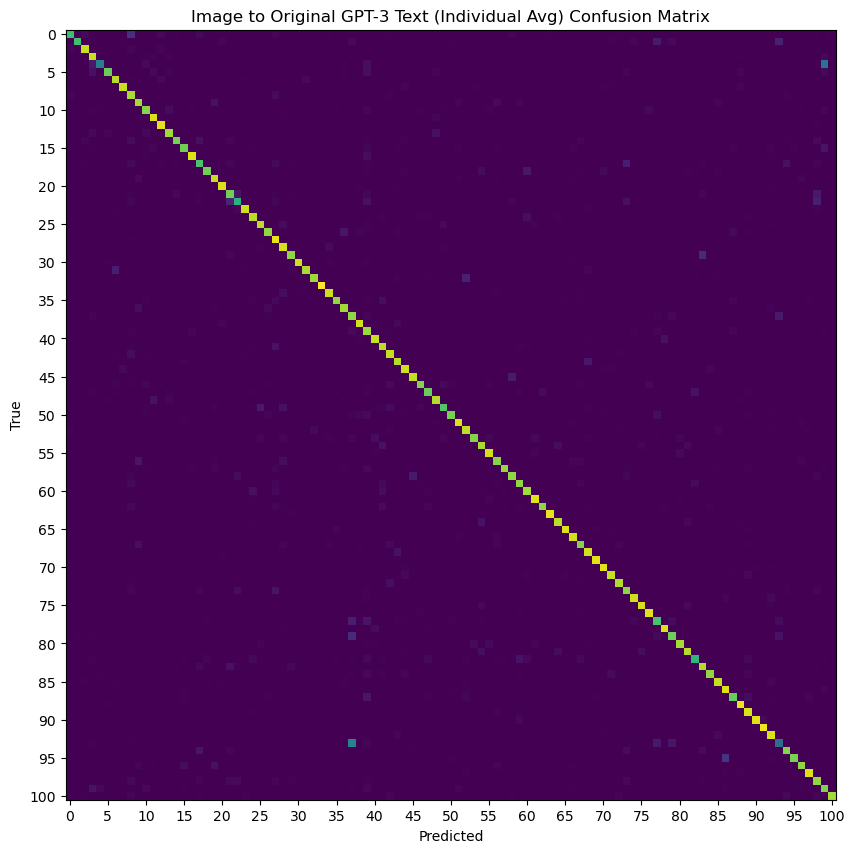

Image to filtered gpt-3 text (centroid) similarity mean: 0.2076416015625
Image to filtered gpt-3 text (centroid) similarity std: 0.028656005859375
Image to filtered gpt-3 text (centroid) similarity diagonal mean: 0.3271484375
Image to filtered gpt-3 text (centroid) similarity diagonal std: 0.0142059326171875
Image to filtered gpt-3 text (centroid) similarity non-diagonal mean: 0.206298828125
Image to filtered gpt-3 text (centroid) similarity non-diagonal std: 0.0261383056640625
Image to filtered gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.5859375
Rank 1: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, similarity: 0.31982421875
Rank 2: (54)(Image)hot_and_sour_soup - (64)(Text)miso_soup, similarity: 0.315185546875
Rank 3: (52)(Image)gyoza - (32)(Text)dumplings, similarity: 0.314208984375
Rank 4: (64)(Image)miso_soup - (54)(Text)hot_and_sour_soup, similarity: 0.31298828125
Rank 5: (99)(Image)tuna_tartare - (4)(Text)beef_tartare, similarity: 0.3076171875
R

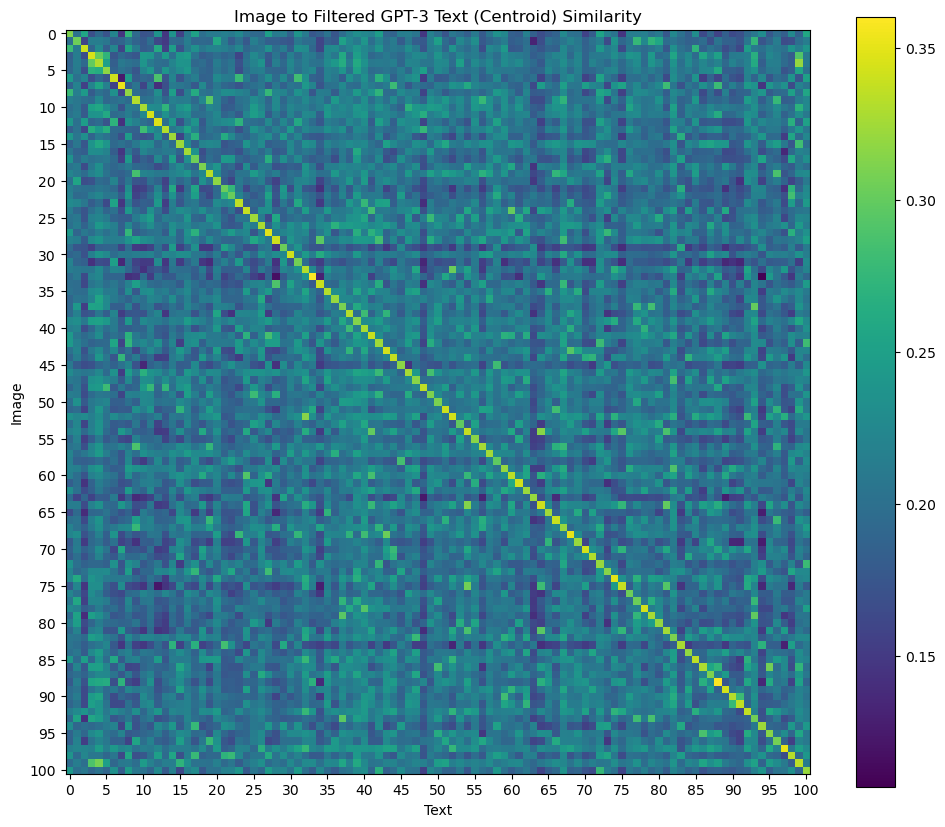

Rank 1: (93)(Image)steak - (37)(Text)filet_mignon, error rate: 0.23333333333333334
Rank 2: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, error rate: 0.23
Rank 3: (37)(Image)filet_mignon - (93)(Text)steak, error rate: 0.18
Rank 4: (58)(Image)ice_cream - (45)(Text)frozen_yogurt, error rate: 0.17666666666666667
Rank 5: (29)(Image)cup_cakes - (83)(Text)red_velvet_cake, error rate: 0.12333333333333334
Rank 6: (21)(Image)chocolate_cake - (98)(Text)tiramisu, error rate: 0.1
Rank 7: (22)(Image)chocolate_mousse - (98)(Text)tiramisu, error rate: 0.1
Rank 8: (0)(Image)apple_pie - (8)(Text)bread_pudding, error rate: 0.09666666666666666
Rank 9: (22)(Image)chocolate_mousse - (21)(Text)chocolate_cake, error rate: 0.08333333333333333
Rank 10: (43)(Image)fried_calamari - (68)(Text)onion_rings, error rate: 0.08333333333333333
Rank 11: (95)(Image)sushi - (86)(Text)sashimi, error rate: 0.08333333333333333
Rank 12: (93)(Image)steak - (77)(Text)pork_chop, error rate: 0.08
Rank 13: (93)(Image)steak - (79)

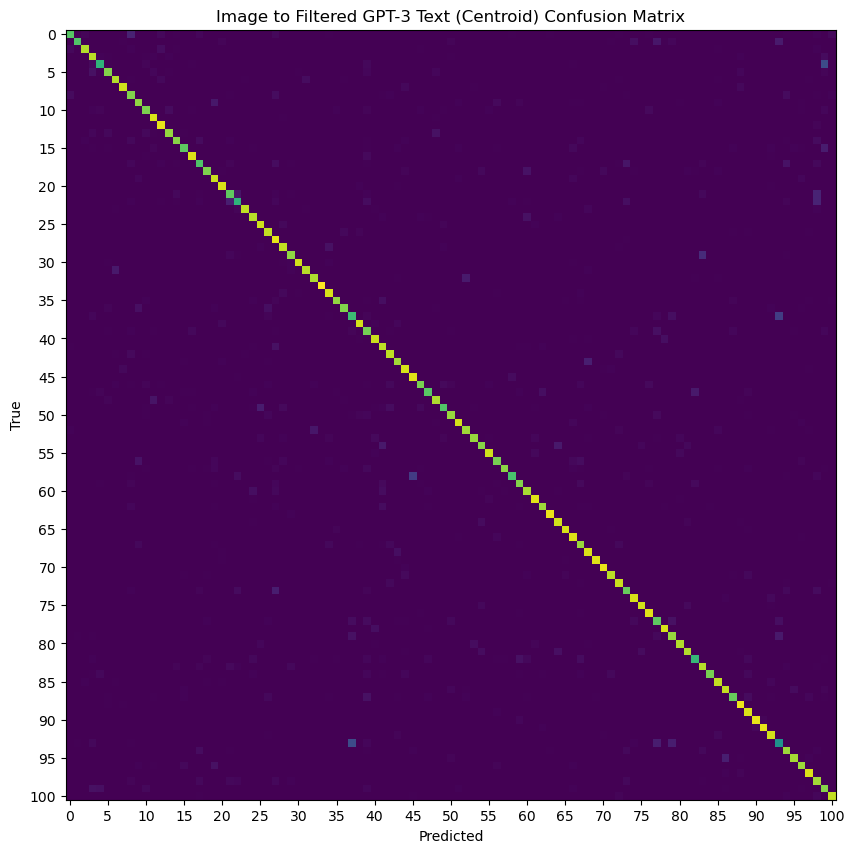

Image to filtered gpt-3 text (individual avg) similarity mean: 0.19632549583911896
Image to filtered gpt-3 text (individual avg) similarity std: 0.027013065293431282
Image to filtered gpt-3 text (individual avg) similarity diagonal mean: 0.3095340430736542
Image to filtered gpt-3 text (individual avg) similarity diagonal std: 0.014113876968622208
Image to filtered gpt-3 text (individual avg) similarity non-diagonal mean: 0.19519340991973877
Image to filtered gpt-3 text (individual avg) similarity non-diagonal std: 0.024608276784420013
Image to filtered gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.585781216621399
Rank 1: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, similarity: 0.308349609375
Rank 2: (54)(Image)hot_and_sour_soup - (64)(Text)miso_soup, similarity: 0.297119140625
Rank 3: (64)(Image)miso_soup - (54)(Text)hot_and_sour_soup, similarity: 0.295654296875
Rank 4: (52)(Image)gyoza - (32)(Text)dumplings, similarity: 0.2939453125
Rank 5: (75

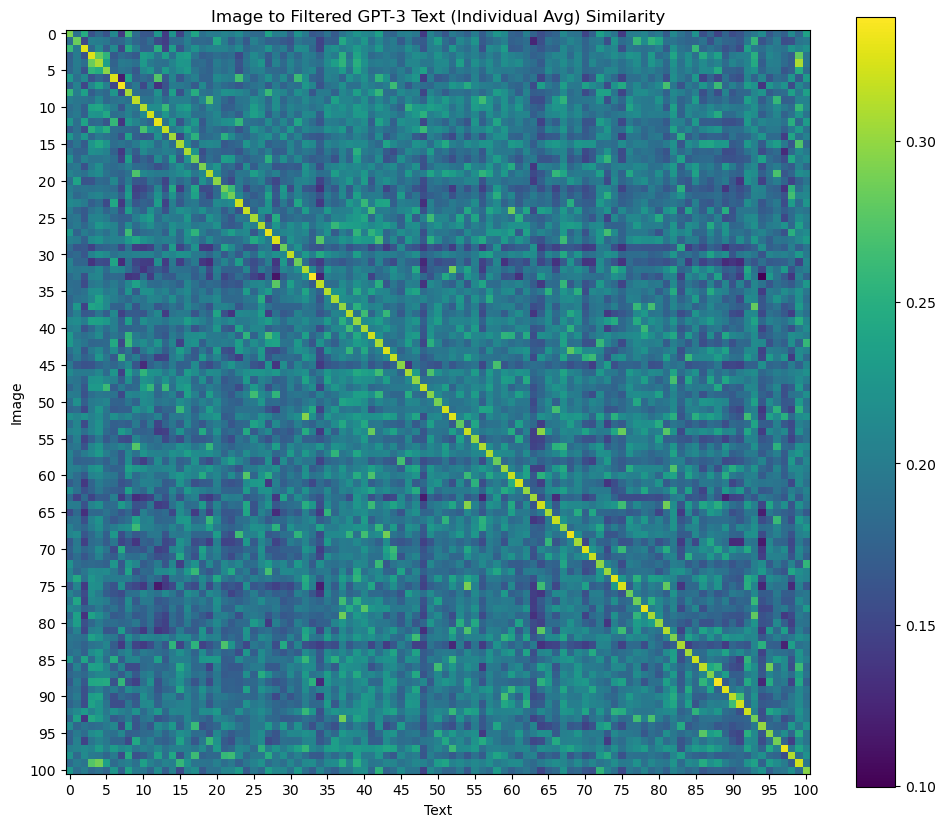

Rank 1: (4)(Image)beef_tartare - (99)(Text)tuna_tartare, error rate: 0.48
Rank 2: (93)(Image)steak - (37)(Text)filet_mignon, error rate: 0.43666666666666665
Rank 3: (95)(Image)sushi - (86)(Text)sashimi, error rate: 0.15333333333333332
Rank 4: (0)(Image)apple_pie - (8)(Text)bread_pudding, error rate: 0.12666666666666668
Rank 5: (29)(Image)cup_cakes - (83)(Text)red_velvet_cake, error rate: 0.12666666666666668
Rank 6: (79)(Image)prime_rib - (37)(Text)filet_mignon, error rate: 0.12333333333333334
Rank 7: (15)(Image)ceviche - (99)(Text)tuna_tartare, error rate: 0.10666666666666667
Rank 8: (22)(Image)chocolate_mousse - (21)(Text)chocolate_cake, error rate: 0.09666666666666666
Rank 9: (58)(Image)ice_cream - (45)(Text)frozen_yogurt, error rate: 0.09333333333333334
Rank 10: (32)(Image)dumplings - (52)(Text)gyoza, error rate: 0.09333333333333334
Rank 11: (93)(Image)steak - (79)(Text)prime_rib, error rate: 0.09
Rank 12: (22)(Image)chocolate_mousse - (98)(Text)tiramisu, error rate: 0.0866666666666

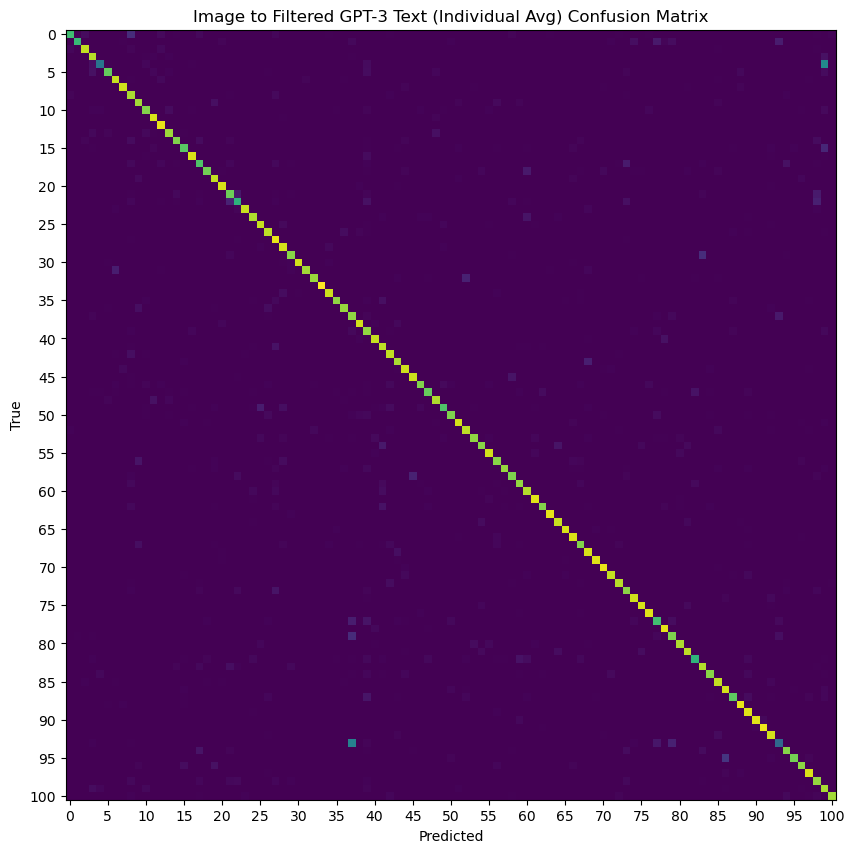

In [37]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, cls_name_cm, 'Image to Class Name')
visualize_cross_similarity(img_template_cls_similarity, template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(img_template_text_similarity, template_text_cm, 'Image to Text Template (Individual Avg)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, original_gpt3_cls_cm, 'Image to Original GPT-3 Text (Centroid)')
visualize_cross_similarity(img_original_gpt3_text_similarity, original_gpt3_text_cm, 'Image to Original GPT-3 Text (Individual Avg)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, filtered_gpt3_cls_cm, 'Image to Filtered GPT-3 Text (Centroid)')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, filtered_gpt3_text_cm, 'Image to Filtered GPT-3 Text (Individual Avg)')

In [38]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [39]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [40]:
def calc_centroid(features, label_ids):
    return [features[label_ids == label_id].mean(axis=0) for label_id in range(len(cls_names_sorted))]

In [41]:
cls_name_transformed_features = transformed_features[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_label_ids = all_label_ids[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_centroids = calc_centroid(cls_name_transformed_features, cls_name_transformed_label_ids)
template_transformed_features = transformed_features[template_start_idx:template_end_idx]
template_transformed_label_ids = all_label_ids[template_start_idx:template_end_idx]
template_transformed_centroids = calc_centroid(template_transformed_features, template_transformed_label_ids)
original_gpt3_transformed_features = transformed_features[original_gpt3_start_idx:original_gpt3_end_idx]
original_gpt3_transformed_label_ids = all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx]
original_gpt3_transformed_centroids = calc_centroid(original_gpt3_transformed_features, original_gpt3_transformed_label_ids)
filtered_gpt3_transformed_features = transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx]
filtered_gpt3_transformed_label_ids = all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx]
filtered_gpt3_transformed_centroids = calc_centroid(filtered_gpt3_transformed_features, filtered_gpt3_transformed_label_ids)

In [42]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.title(title)
    plt.show()

Rank 1: (45)(coor=-4,46)frozen_yogurt - (58)(coor=-4,46)ice_cream, similarity: 0.9013671875
Rank 2: (72)(coor=5,28)pancakes - (100)(coor=5,28)waffles, similarity: 0.8916015625
Rank 3: (21)(coor=12,52)chocolate_cake - (22)(coor=12,52)chocolate_mousse, similarity: 0.890625
Rank 4: (37)(coor=26,-6)filet_mignon - (93)(coor=26,-6)steak, similarity: 0.87744140625
Rank 5: (38)(coor=-9,-2)fish_and_chips - (40)(coor=-9,-2)french_fries, similarity: 0.87646484375
Rank 6: (66)(coor=1,-18)nachos - (96)(coor=1,-18)tacos, similarity: 0.873046875
Rank 7: (86)(coor=-9,-27)sashimi - (95)(coor=-9,-27)sushi, similarity: 0.87158203125
Rank 8: (4)(coor=38,-48)beef_tartare - (99)(coor=38,-48)tuna_tartare, similarity: 0.86572265625
Rank 9: (76)(coor=2,11)pizza - (93)(coor=2,11)steak, similarity: 0.865234375
Rank 10: (21)(coor=12,52)chocolate_cake - (29)(coor=12,52)cup_cakes, similarity: 0.8642578125


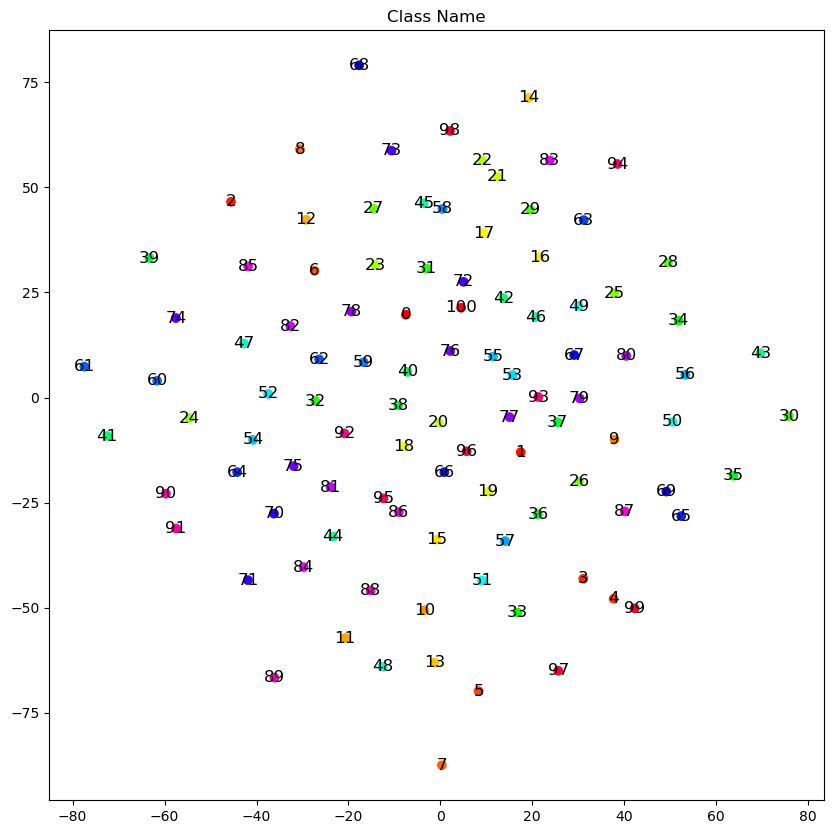

Rank 1: (21)(coor=11,52)chocolate_cake - (22)(coor=11,52)chocolate_mousse, similarity: 0.90283203125
Rank 2: (45)(coor=-4,46)frozen_yogurt - (58)(coor=-4,46)ice_cream, similarity: 0.8994140625
Rank 3: (4)(coor=36,-47)beef_tartare - (99)(coor=36,-47)tuna_tartare, similarity: 0.8974609375
Rank 4: (86)(coor=-8,-27)sashimi - (95)(coor=-8,-27)sushi, similarity: 0.8896484375
Rank 5: (37)(coor=25,-7)filet_mignon - (93)(coor=25,-7)steak, similarity: 0.8876953125
Rank 6: (72)(coor=4,25)pancakes - (100)(coor=4,25)waffles, similarity: 0.88720703125
Rank 7: (53)(coor=15,4)hamburger - (93)(coor=15,4)steak, similarity: 0.88671875
Rank 8: (77)(coor=14,-4)pork_chop - (93)(coor=14,-4)steak, similarity: 0.88134765625
Rank 9: (53)(coor=15,4)hamburger - (55)(coor=15,4)hot_dog, similarity: 0.86474609375
Rank 10: (79)(coor=29,0)prime_rib - (93)(coor=29,0)steak, similarity: 0.86474609375


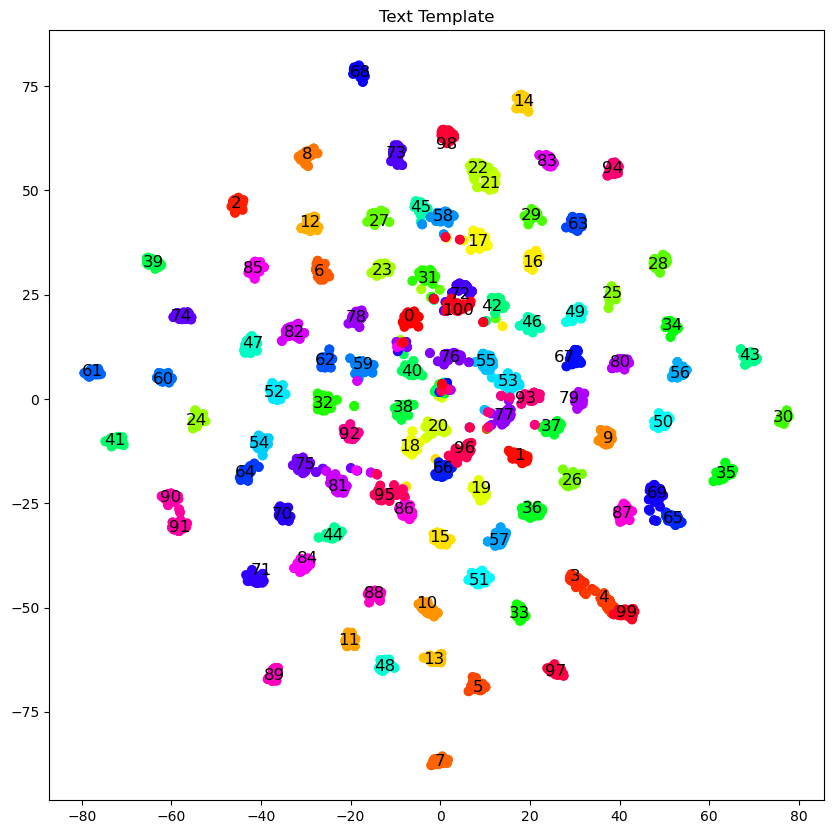

Rank 1: (37)(coor=24,-4)filet_mignon - (93)(coor=24,-4)steak, similarity: 0.93505859375
Rank 2: (45)(coor=-2,45)frozen_yogurt - (58)(coor=-2,45)ice_cream, similarity: 0.9306640625
Rank 3: (4)(coor=35,-43)beef_tartare - (99)(coor=35,-43)tuna_tartare, similarity: 0.91650390625
Rank 4: (86)(coor=-10,-28)sashimi - (95)(coor=-10,-28)sushi, similarity: 0.91552734375
Rank 5: (79)(coor=27,-1)prime_rib - (93)(coor=27,-1)steak, similarity: 0.9150390625
Rank 6: (77)(coor=17,-5)pork_chop - (93)(coor=17,-5)steak, similarity: 0.90576171875
Rank 7: (53)(coor=17,7)hamburger - (55)(coor=17,7)hot_dog, similarity: 0.90478515625
Rank 8: (21)(coor=14,52)chocolate_cake - (22)(coor=14,52)chocolate_mousse, similarity: 0.90185546875
Rank 9: (72)(coor=6,29)pancakes - (100)(coor=6,29)waffles, similarity: 0.90087890625
Rank 10: (54)(coor=-42,-11)hot_and_sour_soup - (64)(coor=-42,-11)miso_soup, similarity: 0.8984375


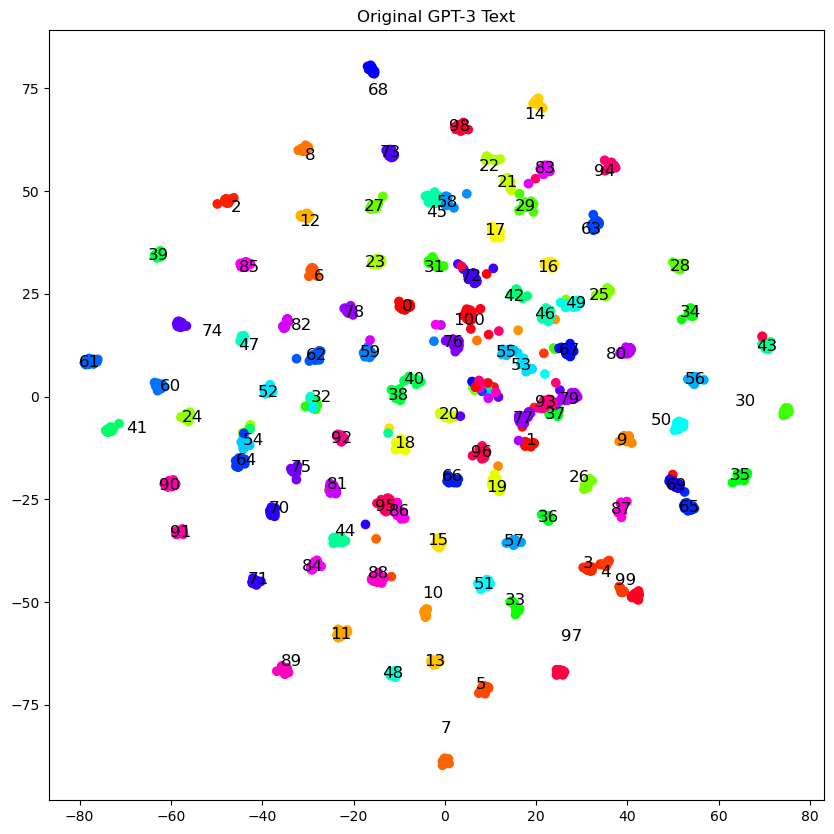

Rank 1: (37)(coor=24,-4)filet_mignon - (93)(coor=24,-4)steak, similarity: 0.9365234375
Rank 2: (45)(coor=-2,46)frozen_yogurt - (58)(coor=-2,46)ice_cream, similarity: 0.92724609375
Rank 3: (86)(coor=-10,-28)sashimi - (95)(coor=-10,-28)sushi, similarity: 0.9140625
Rank 4: (79)(coor=28,-0)prime_rib - (93)(coor=28,-0)steak, similarity: 0.91162109375
Rank 5: (4)(coor=37,-43)beef_tartare - (99)(coor=37,-43)tuna_tartare, similarity: 0.91015625
Rank 6: (77)(coor=17,-5)pork_chop - (93)(coor=17,-5)steak, similarity: 0.90576171875
Rank 7: (53)(coor=17,8)hamburger - (55)(coor=17,8)hot_dog, similarity: 0.904296875
Rank 8: (21)(coor=14,52)chocolate_cake - (22)(coor=14,52)chocolate_mousse, similarity: 0.9013671875
Rank 9: (72)(coor=6,29)pancakes - (100)(coor=6,29)waffles, similarity: 0.90087890625
Rank 10: (53)(coor=17,8)hamburger - (93)(coor=17,8)steak, similarity: 0.89697265625


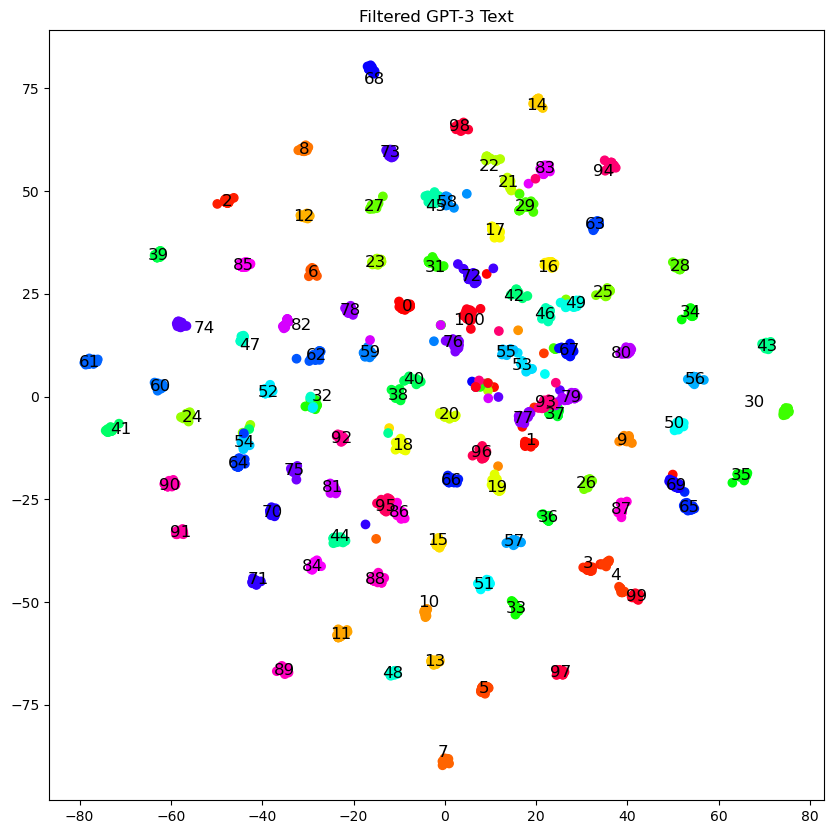

In [43]:
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity', coordinates=cls_name_transformed_centroids)
plot_features_2d(cls_name_transformed_features, cls_name_transformed_label_ids, 'Class Name')
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity', coordinates=template_transformed_centroids)
plot_features_2d(template_transformed_features, template_transformed_label_ids, 'Text Template')
print_top_pairs(np.triu(original_gpt3_masked_similarity, k=1), 'similarity', coordinates=original_gpt3_transformed_centroids)
plot_features_2d(original_gpt3_transformed_features, original_gpt3_transformed_label_ids, 'Original GPT-3 Text')
print_top_pairs(np.triu(filtered_gpt3_masked_similarity, k=1), 'similarity', coordinates=filtered_gpt3_transformed_centroids)
plot_features_2d(filtered_gpt3_transformed_features, filtered_gpt3_transformed_label_ids, 'Filtered GPT-3 Text')